In [3]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Fer+ Balanced

# New Load

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/train", transform=transform)
val_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/val", transform=transform)
test_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
print("✅ Classes:", class_names)


✅ Classes: ['1', '2', '3', '4', '5', '6', '7']


In [5]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [6]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [7]:


# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze backbone (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

model = model.to(device)



/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/enulu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.44MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


Epoch 1/10 | Avg Loss: 1.4988 | Train Acc: 0.4364 | Val Acc: 0.4996
Epoch 2/10 | Avg Loss: 1.3482 | Train Acc: 0.5005 | Val Acc: 0.4784
Epoch 3/10 | Avg Loss: 1.3013 | Train Acc: 0.5140 | Val Acc: 0.5102
Epoch 4/10 | Avg Loss: 1.2722 | Train Acc: 0.5291 | Val Acc: 0.5233
Epoch 5/10 | Avg Loss: 1.2548 | Train Acc: 0.5360 | Val Acc: 0.5167
Epoch 6/10 | Avg Loss: 1.2275 | Train Acc: 0.5519 | Val Acc: 0.5249
Epoch 7/10 | Avg Loss: 1.2108 | Train Acc: 0.5544 | Val Acc: 0.5429
Epoch 8/10 | Avg Loss: 1.2075 | Train Acc: 0.5561 | Val Acc: 0.5396
Epoch 9/10 | Avg Loss: 1.1952 | Train Acc: 0.5575 | Val Acc: 0.5061
Epoch 10/10 | Avg Loss: 1.1822 | Train Acc: 0.5622 | Val Acc: 0.5257


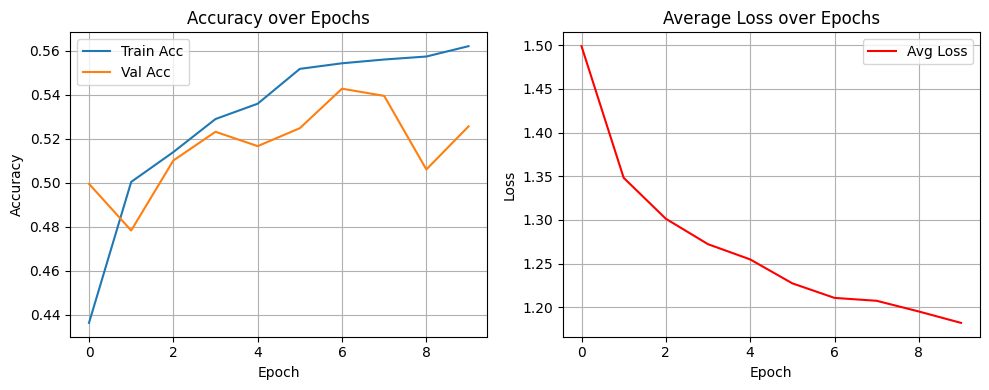

In [9]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.5164

🔍 Classification Report:

              precision    recall  f1-score   support

           1       0.46      0.57      0.51       329
           2       0.89      0.11      0.19        74
           3       0.14      0.01      0.01       160
           4       0.64      0.73      0.68      1185
           5       0.57      0.30      0.39       478
           6       0.62      0.17      0.27       162
           7       0.45      0.66      0.53       680

    accuracy                           0.55      3068
   macro avg       0.54      0.36      0.37      3068
weighted avg       0.55      0.55      0.52      3068



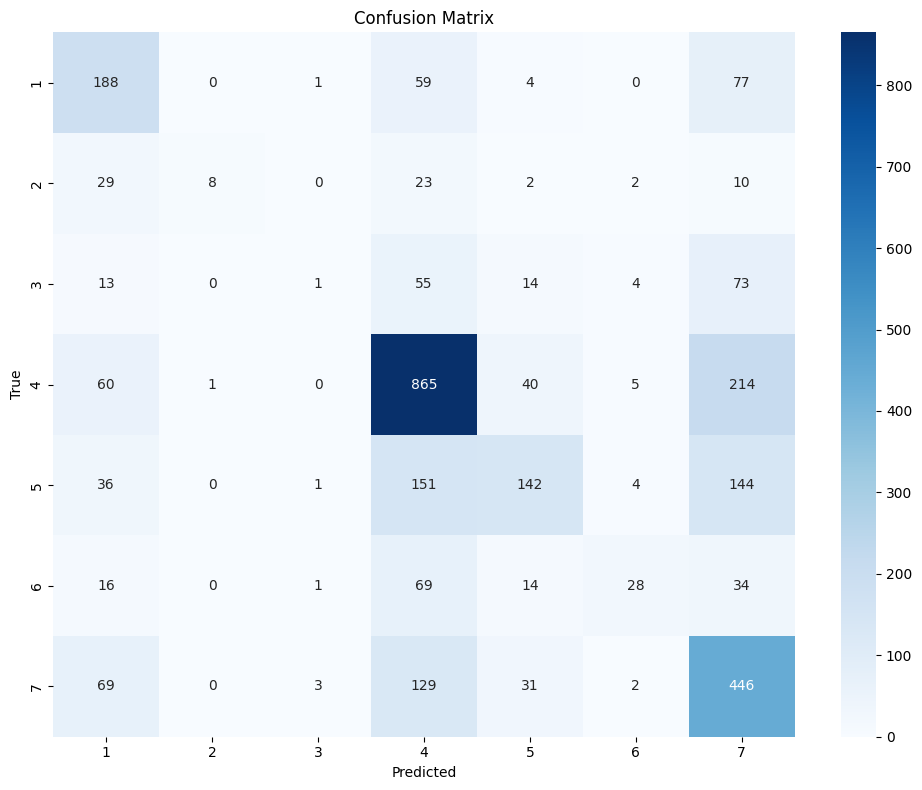

In [10]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#20 epoch


In [11]:


# Load pretrained ResNet50
model20 = models.resnet50(pretrained=True)

# Freeze backbone (optional)
for param in model20.parameters():
    param.requires_grad = False

# Replace classifier head
model20.fc = nn.Sequential(
    nn.Linear(model20.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

model20 = model20.to(device)



/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Avg Loss: 1.9847 | Train Acc: 0.0940 | Val Acc: 0.0849
Epoch 2/20 | Avg Loss: 1.9838 | Train Acc: 0.0989 | Val Acc: 0.0841
Epoch 3/20 | Avg Loss: 1.9851 | Train Acc: 0.0943 | Val Acc: 0.0800
Epoch 4/20 | Avg Loss: 1.9854 | Train Acc: 0.0897 | Val Acc: 0.0792
Epoch 5/20 | Avg Loss: 1.9830 | Train Acc: 0.0998 | Val Acc: 0.0800
Epoch 6/20 | Avg Loss: 1.9846 | Train Acc: 0.0951 | Val Acc: 0.0816
Epoch 7/20 | Avg Loss: 1.9850 | Train Acc: 0.0985 | Val Acc: 0.0824
Epoch 8/20 | Avg Loss: 1.9827 | Train Acc: 0.1011 | Val Acc: 0.0784
Epoch 9/20 | Avg Loss: 1.9851 | Train Acc: 0.0970 | Val Acc: 0.0808
Epoch 10/20 | Avg Loss: 1.9849 | Train Acc: 0.0949 | Val Acc: 0.0808
Epoch 11/20 | Avg Loss: 1.9847 | Train Acc: 0.0971 | Val Acc: 0.0792
Epoch 12/20 | Avg Loss: 1.9844 | Train Acc: 0.0911 | Val Acc: 0.0816
Epoch 13/20 | Avg Loss: 1.9847 | Train Acc: 0.0946 | Val Acc: 0.0784
Epoch 14/20 | Avg Loss: 1.9832 | Train Acc: 0.0973 | Val Acc: 0.0792
Epoch 15/20 | Avg Loss: 1.9825 | Train Acc:

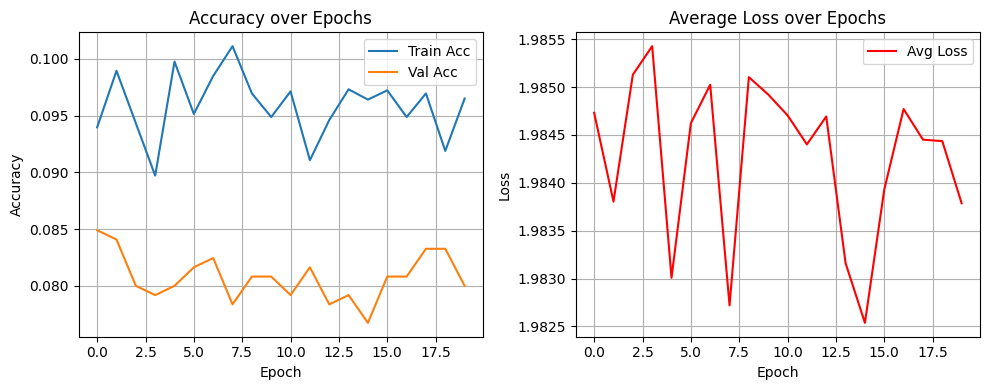

In [12]:
model20 = train_model(model20, train_loader, val_loader, criterion, optimizer, epochs=20)

✅ Weighted F1 Score: 0.5164

🔍 Classification Report:

              precision    recall  f1-score   support

           1       0.46      0.57      0.51       329
           2       0.89      0.11      0.19        74
           3       0.14      0.01      0.01       160
           4       0.64      0.73      0.68      1185
           5       0.57      0.30      0.39       478
           6       0.62      0.17      0.27       162
           7       0.45      0.66      0.53       680

    accuracy                           0.55      3068
   macro avg       0.54      0.36      0.37      3068
weighted avg       0.55      0.55      0.52      3068



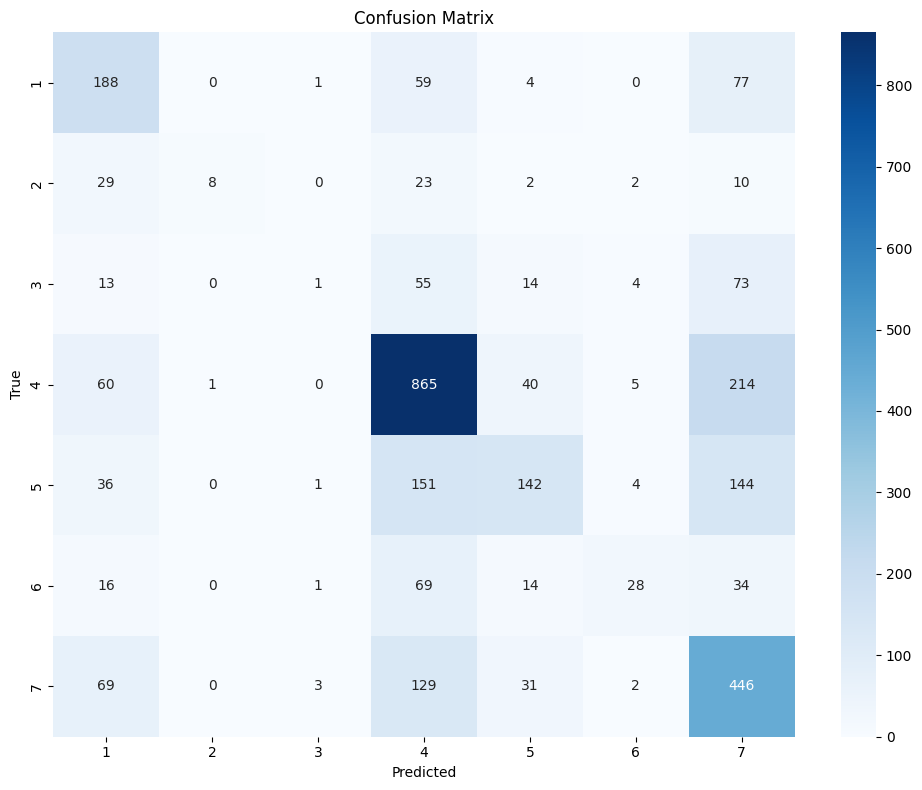

In [13]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

model20.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Entire ResNet50 Training

In [14]:


# Load pretrained ResNet50
entire_model = models.resnet50(pretrained=True)

# Freeze backbone (optional) CHANGED FOR ENTIRE RESNET50 TRAINING
for param in entire_model.parameters():
    param.requires_grad = True

# Replace classifier head
entire_model.fc = nn.Sequential(
    nn.Linear(entire_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

entire_model = entire_model.to(device)



/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(entire_model.fc.parameters(), lr=1e-5)


Epoch 1/10 | Avg Loss: 1.6753 | Train Acc: 0.3816 | Val Acc: 0.3894
Epoch 2/10 | Avg Loss: 1.5876 | Train Acc: 0.3950 | Val Acc: 0.3951
Epoch 3/10 | Avg Loss: 1.5459 | Train Acc: 0.4143 | Val Acc: 0.4302
Epoch 4/10 | Avg Loss: 1.5127 | Train Acc: 0.4281 | Val Acc: 0.4490
Epoch 5/10 | Avg Loss: 1.4798 | Train Acc: 0.4453 | Val Acc: 0.4686
Epoch 6/10 | Avg Loss: 1.4556 | Train Acc: 0.4587 | Val Acc: 0.4612
Epoch 7/10 | Avg Loss: 1.4308 | Train Acc: 0.4729 | Val Acc: 0.4718
Epoch 8/10 | Avg Loss: 1.4109 | Train Acc: 0.4821 | Val Acc: 0.4776
Epoch 9/10 | Avg Loss: 1.3949 | Train Acc: 0.4867 | Val Acc: 0.4759
Epoch 10/10 | Avg Loss: 1.3778 | Train Acc: 0.4924 | Val Acc: 0.4849


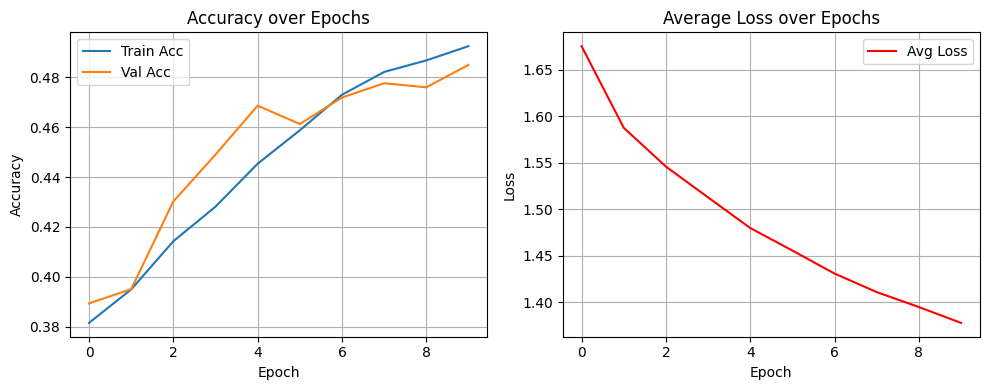

In [16]:
entire_model = train_model(entire_model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.4290

🔍 Classification Report:

              precision    recall  f1-score   support

           1       0.66      0.28      0.39       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.50      0.89      0.64      1185
           5       0.45      0.20      0.28       478
           6       1.00      0.01      0.01       162
           7       0.46      0.41      0.43       680

    accuracy                           0.50      3068
   macro avg       0.44      0.25      0.25      3068
weighted avg       0.49      0.50      0.43      3068



/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


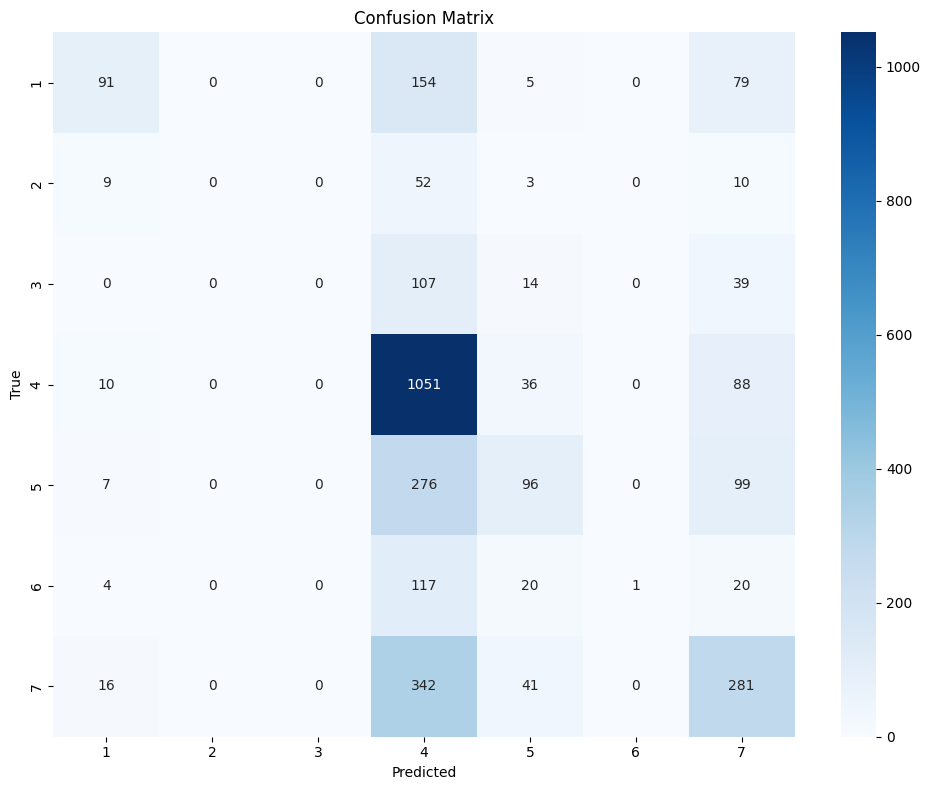

In [17]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

entire_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = entire_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
